# Animal classification

## 0. Description

Let's make an application that identifies which animal appears in the picture given. We are going to get the data, train the model and put it into production.

## 1. Libraries

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier

import skimage

import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

## 2. Importing the data

### `2.1. Base case`

Veamos como se carga una sola imagen y se muestra en pantalla:

In [9]:
img=plt.imread('data/LionHead/lion007.jpg')
img.shape

(80, 80, 3)

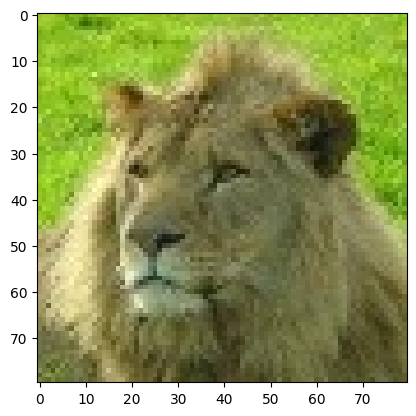

In [10]:
plt.imshow(img)

### `2.2. Real case`

Generamos dos listas, una con todas las imágenes cargadas con la ruta, y otra con las etiquetas, que serán las carpetas de nuestro directorio.

In [11]:
data=os.listdir('data')
img_list=[]
label_list=[]
for folder in data:
    for file in os.listdir('data/'+folder):
        if os.path.isfile('data/'+folder+'/'+file):
            img=plt.imread('data/'+folder+'/'+file)
            label_list.append(folder)
            img_list.append(img)

In [12]:
df=pd.DataFrame(data={"img":img_list,"label":label_list})
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 215,...",BearHead
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",BearHead
2,"[[[104, 109, 102], [105, 110, 103], [108, 115,...",BearHead
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",BearHead
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",BearHead


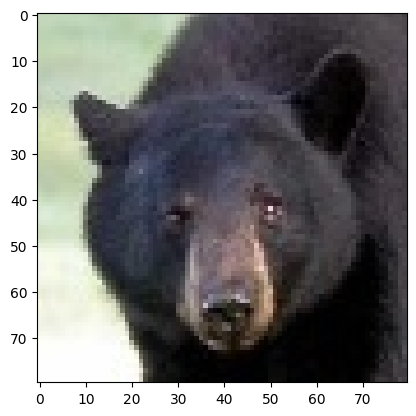

In [13]:
plt.imshow(df.loc[0,'img'])

### `2.3. Label names`

In [14]:
i=0
for word in df['label']:
    df.iloc[i,1]=word.replace('Head','')
    i+=1

In [15]:
df.label.unique()

array(['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle',
       'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Natural', 'Panda',
       'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf'], dtype=object)

In [16]:
df.shape

(2057, 2)

### `2.4. Trial`

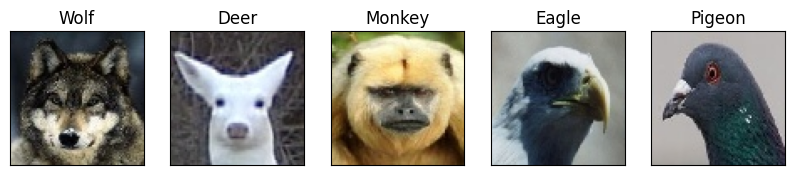

In [17]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,df.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(df.loc[j,'img'])
    plt.title(df.loc[j,'label'])

We can repeat this execution every time we want in order to check if the labels are right.

### `2.5. Data saving`

In [18]:
with open('pickle_files/diego_dataframe.pkl','wb') as f:
    pickle.dump(df,f)

## 3. Modeling

### `3.0. Label encoding`

In [19]:
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 215,...",Bear
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",Bear
2,"[[[104, 109, 102], [105, 110, 103], [108, 115,...",Bear
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",Bear
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",Bear


In [20]:
dict_labels={}
i=0
for label in df.label.unique():
    dict_labels[label]=i
    i+=1
print(dict_labels)

{'Bear': 0, 'Cat': 1, 'Chicken': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Duck': 6, 'Eagle': 7, 'Elephant': 8, 'Human': 9, 'Lion': 10, 'Monkey': 11, 'Mouse': 12, 'Natural': 13, 'Panda': 14, 'Pigeon': 15, 'Rabbit': 16, 'Sheep': 17, 'Tiger': 18, 'Wolf': 19}


In [21]:
mapeo={}
for key in dict_labels.keys():
    mapeo[dict_labels[key]]=key
print(mapeo)

{0: 'Bear', 1: 'Cat', 2: 'Chicken', 3: 'Cow', 4: 'Deer', 5: 'Dog', 6: 'Duck', 7: 'Eagle', 8: 'Elephant', 9: 'Human', 10: 'Lion', 11: 'Monkey', 12: 'Mouse', 13: 'Natural', 14: 'Panda', 15: 'Pigeon', 16: 'Rabbit', 17: 'Sheep', 18: 'Tiger', 19: 'Wolf'}


Let's save the mapping

In [22]:
with open('pickle_files/diego_mapeo.pkl','wb') as f:
    pickle.dump(mapeo,f)

In [23]:
df["label_2"]=0

In [24]:
for i in range(df.shape[0]):
    df.iloc[i,2]=dict_labels[df.iloc[i,1]]
df.sample(5)

,img,label,label_2
1748,"[[[160, 191, 222], [162, 193, 224], [163, 194,...",Sheep,17
1372,"[[[219, 219, 219], [219, 219, 219], [217, 219,...",Mouse,12
97,"[[[154, 152, 113], [155, 153, 115], [160, 159,...",Bear,0
977,"[[[53, 46, 28], [50, 44, 28], [26, 24, 9], [5,...",Elephant,8
727,"[[[156, 155, 153], [148, 147, 143], [139, 138,...",Duck,6


In [25]:
df["label"]=df["label_2"]
df.drop(columns=["label_2"],inplace=True)
df.sample(5)

,img,label
1695,"[[[122, 138, 6], [136, 148, 12], [154, 162, 17...",16
427,"[[[185, 155, 43], [183, 153, 41], [180, 150, 3...",3
1818,"[[[89, 82, 66], [91, 82, 65], [104, 91, 72], [...",17
1179,"[[[150, 111, 54], [155, 118, 63], [140, 102, 5...",10
1127,"[[[53, 81, 59], [52, 81, 59], [50, 81, 63], [4...",10


### ``3.1. Data split``

In [26]:
x_train,x_test,y_train,y_test=train_test_split(df['img'],df['label'],test_size=0.2,random_state=42)

In [27]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645,), (412,), (1645,), (412,))

We need to change the format of the images.

In [28]:
x_train=np.array(x_train.tolist())
x_test=np.array(x_test.tolist())
x_train.shape,x_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3))

In [29]:
y_train

67       0
1001     9
567      5
1271    11
1666    16
        ..
1638    15
1095     9
1130    10
1294    11
860      7
Name: label, Length: 1645, dtype: int64

### `3.2. Encoding`

In [30]:
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)
type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray)

In [31]:
x_train=np.array(x_train/255)
x_test=np.array(x_test/255)
type(x_train),type(x_test)

(numpy.ndarray, numpy.ndarray)

In [32]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3), (1645,), (412,))

### ``3.3. Modeling and training``

#### First neural network (linear regression)

In [33]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [34]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
# history = model.fit(x_train,y_train,epochs=30, use_multiprocessing=False, verbose=False, validation_data=(x_test, y_test))
history = model.fit(x_train,y_train,epochs=30, verbose=False, validation_data=(x_test, y_test))
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

52/52 [==============================] - 0s 3ms/step - loss: 0.4377 - accuracy: 0.8693
Training Accuracy: 0.8693


In [36]:
def training_plot( metricas, history):
    plt.figure(figsize=(10,3))
    for i,metrica in enumerate(metricas):
        plt.subplot(1,2,i+1)
        y = history.history[metrica]
        x = [ x+1 for x in range( len( history.history[metrica] ))]
        plt.plot(x,y)
        y = history.history[f'val_{metrica}']
        x = [ x+1 for x in range( len( history.history[f'val_{metrica}'] ))]
        plt.plot(x,y)
        plt.title(metrica)
        plt.legend([f'{metrica}',f'val_{metrica}'])

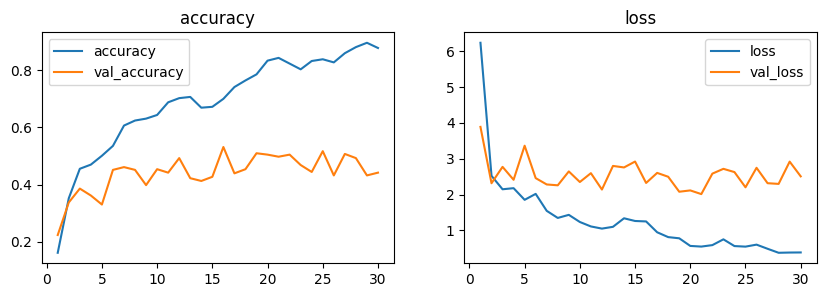

In [37]:
training_plot(['accuracy','loss'],history)

#### Let's define a new neural network now.

In [38]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [40]:
# history = model.fit(x_train,y_train,epochs=10, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=10, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/10
13/13 [==============================] - 4s 263ms/step - loss: 3.6721 - accuracy: 0.1222 - val_loss: 2.7638 - val_accuracy: 0.2354
Epoch 2/10
13/13 [==============================] - 3s 258ms/step - loss: 2.6622 - accuracy: 0.2353 - val_loss: 2.4306 - val_accuracy: 0.2573
Epoch 3/10
13/13 [==============================] - 3s 260ms/step - loss: 2.3632 - accuracy: 0.2875 - val_loss: 2.2707 - val_accuracy: 0.3155
Epoch 4/10
13/13 [==============================] - 3s 245ms/step - loss: 2.2000 - accuracy: 0.3641 - val_loss: 2.1409 - val_accuracy: 0.4102
Epoch 5/10
13/13 [==============================] - 3s 247ms/step - loss: 2.0837 - accuracy: 0.4043 - val_loss: 2.1766 - val_accuracy: 0.3981
Epoch 6/10
13/13 [==============================] - 3s 250ms/step - loss: 1.9664 - accuracy: 0.4389 - val_loss: 2.0210 - val_accuracy: 0.4417
Epoch 7/10
13/13 [==============================] - 3s 236ms/step - loss: 1.8635 - accuracy: 0.4742 - val_loss: 1.9279 - val_accuracy: 0.4393
Epoch 

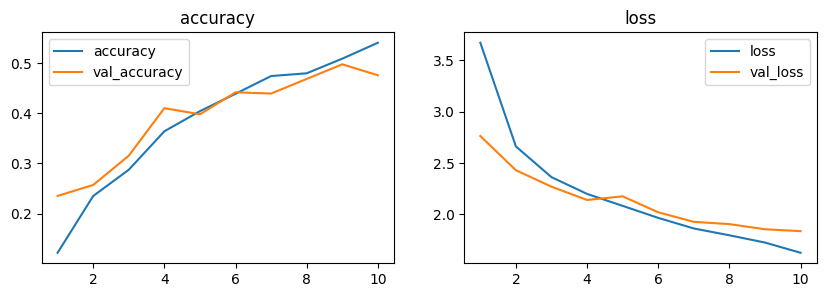

In [41]:
training_plot(['accuracy','loss'],history)

#### Deep neural network (more than one hidden layer)

In [42]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [44]:
# history = model.fit(x_train,y_train,epochs=20, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=20, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20
13/13 [==============================] - 5s 315ms/step - loss: 3.1257 - accuracy: 0.1246 - val_loss: 2.6841 - val_accuracy: 0.1796
Epoch 2/20
13/13 [==============================] - 4s 272ms/step - loss: 2.6780 - accuracy: 0.1878 - val_loss: 2.4507 - val_accuracy: 0.2597
Epoch 3/20
13/13 [==============================] - 4s 271ms/step - loss: 2.5042 - accuracy: 0.2413 - val_loss: 2.3126 - val_accuracy: 0.3301
Epoch 4/20
13/13 [==============================] - 4s 303ms/step - loss: 2.3554 - accuracy: 0.2888 - val_loss: 2.1910 - val_accuracy: 0.3641
Epoch 5/20
13/13 [==============================] - 3s 259ms/step - loss: 2.2093 - accuracy: 0.3356 - val_loss: 2.0683 - val_accuracy: 0.4345
Epoch 6/20
13/13 [==============================] - 3s 258ms/step - loss: 2.1422 - accuracy: 0.3562 - val_loss: 2.0254 - val_accuracy: 0.4078
Epoch 7/20
13/13 [==============================] - 3s 259ms/step - loss: 2.0264 - accuracy: 0.3933 - val_loss: 2.0278 - val_accuracy: 0.4029
Epoch 

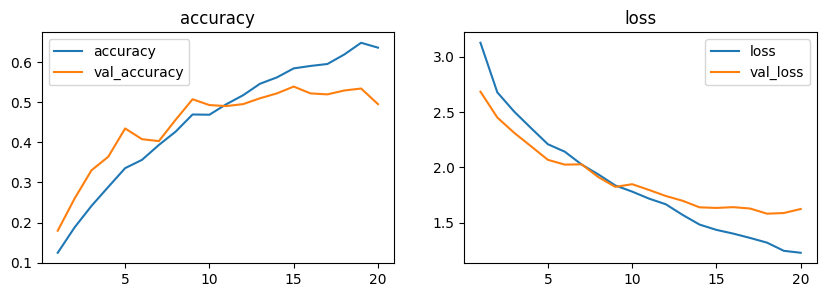

In [45]:
training_plot(['accuracy','loss'],history)

#### Convolutional neural network

In [46]:
layers=[]

layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(80,80,3)))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))
layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))

layers.append(tf.keras.layers.Flatten())
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [48]:
# history = model.fit(x_train,y_train,epochs=20, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=20, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20
13/13 [==============================] - 11s 798ms/step - loss: 2.9038 - accuracy: 0.1258 - val_loss: 2.7995 - val_accuracy: 0.1675
Epoch 2/20
13/13 [==============================] - 8s 653ms/step - loss: 2.6639 - accuracy: 0.2201 - val_loss: 2.4410 - val_accuracy: 0.2985
Epoch 3/20
13/13 [==============================] - 9s 663ms/step - loss: 2.3481 - accuracy: 0.3179 - val_loss: 2.1508 - val_accuracy: 0.3641
Epoch 4/20
13/13 [==============================] - 8s 621ms/step - loss: 2.0711 - accuracy: 0.4079 - val_loss: 1.8723 - val_accuracy: 0.4830
Epoch 5/20
13/13 [==============================] - 8s 633ms/step - loss: 1.7796 - accuracy: 0.4888 - val_loss: 1.6796 - val_accuracy: 0.5340
Epoch 6/20
13/13 [==============================] - 9s 665ms/step - loss: 1.5744 - accuracy: 0.5489 - val_loss: 1.5347 - val_accuracy: 0.5583
Epoch 7/20
13/13 [==============================] - 9s 664ms/step - loss: 1.3737 - accuracy: 0.5982 - val_loss: 1.4392 - val_accuracy: 0.5728
Epoch

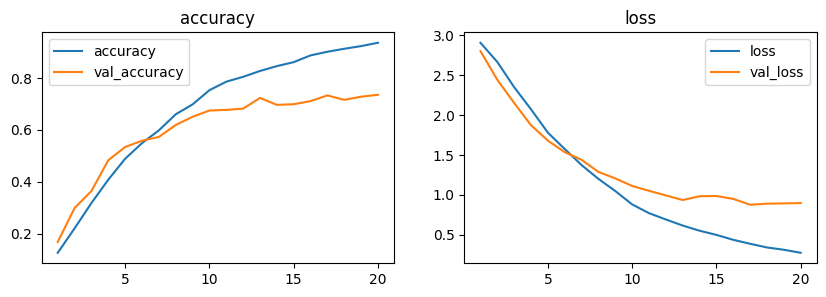

In [49]:
training_plot(['accuracy','loss'],history)

Let's save the model

In [50]:
model.save('model/model.h5')

c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4. Testing

### `4.1. Simple testing`

In [51]:
predictions=model.predict(x_test)

13/13 [==============================] - 1s 44ms/step


In [52]:
predictions.shape

(412, 20)

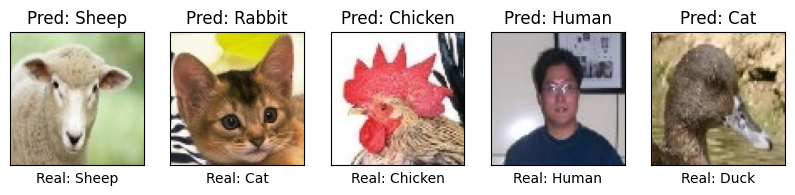

In [53]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,x_test.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[j])
    plt.title(f'Pred: {mapeo[np.argmax(predictions[j])]}')
    plt.xlabel(f'Real: {mapeo[y_test[j]]}')
plt.show()

In [54]:
print(f'Accuracy: {np.sum(np.argmax(predictions,axis=1)==y_test)/y_test.shape[0]}')
print(f'Error: {np.sum(np.argmax(predictions,axis=1)!=y_test)/y_test.shape[0]}')

Accuracy: 0.7354368932038835
Error: 0.2645631067961165


In [55]:
df_pred=pd.DataFrame(data={'pred':np.argmax(predictions,axis=1),'real':y_test})
df_pred.head()

,pred,real
0,10,1
1,18,18
2,1,1
3,10,10
4,14,14


In [56]:
df_pred["real"]=df_pred["real"].apply(lambda x: mapeo[x])
df_pred["pred"]=df_pred["pred"].apply(lambda x: mapeo[x])

In [57]:
df_pred.head()

,pred,real
0,Lion,Cat
1,Tiger,Tiger
2,Cat,Cat
3,Lion,Lion
4,Panda,Panda


In [58]:
df_pred["exito"]=(df_pred["real"]==df_pred["pred"]).astype(int)

In [59]:
df_pred.exito.value_counts()

exito
1    303
0    109
Name: count, dtype: int64

Let's see it in a confussion matrix, which shows how many predictions there were for each label

In [60]:
pd.crosstab(df_pred['real'],df_pred['pred'],margins=True)

pred,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf,All
real,,,,,,,,,,,,,,,,,,,,
Bear,15,1,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,20
Cat,0,26,0,0,0,1,0,0,0,0,2,1,1,0,0,1,0,0,1,33
Chicken,0,0,23,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,25
Cow,1,0,0,8,1,2,0,0,1,1,0,0,1,0,0,0,7,0,0,22
Deer,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,1,1,0,2,23
Dog,0,2,0,0,0,15,1,0,2,0,1,0,1,0,0,1,1,0,0,24
Duck,0,2,0,0,0,0,17,0,0,0,0,0,0,0,0,0,1,0,0,20
Eagle,0,0,0,0,0,0,4,7,0,0,0,0,1,3,3,0,1,0,0,19
Elephant,0,0,0,0,0,1,0,0,20,0,0,0,1,0,0,0,3,0,0,25


In [61]:
import sklearn.metrics as metrics

In [62]:
pd.DataFrame(metrics.classification_report(df_pred['real'],df_pred['pred'],output_dict=True)).T.sort_values(by='f1-score',ascending=False)

c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

,precision,recall,f1-score,support
Chicken,1.000000,0.920000,0.958333,25.000000
Human,0.950000,0.950000,0.950000,20.000000
Panda,0.850000,0.944444,0.894737,18.000000
Deer,0.950000,0.826087,0.883721,23.000000
Tiger,0.823529,0.823529,0.823529,17.000000
Wolf,0.869565,0.769231,0.816327,26.000000
Elephant,0.833333,0.800000,0.816327,25.000000
Bear,0.833333,0.750000,0.789474,20.000000
Pigeon,0.842105,0.727273,0.780488,22.000000
Cat,0.742857,0.787879,0.764706,33.000000


In [63]:
pd.options.display.float_format = '{:.4f}'.format
df_proba=pd.DataFrame(predictions,columns=[mapeo[i] for i in range(20)])
df_proba

,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Natural,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf
0,0.0076,0.0303,0.0002,0.0049,0.0088,0.0664,0.0374,0.0077,0.1262,0.0049,0.4231,0.0099,0.0753,0.0167,0.0001,0.0043,0.0682,0.0163,0.0067,0.0851
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9995,0.0000
2,0.0001,0.9902,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0019,0.0000,0.0035,0.0000,0.0006,0.0034,0.0000,0.0001
3,0.0054,0.0007,0.0002,0.0018,0.0001,0.0063,0.0031,0.0001,0.0030,0.0007,0.9748,0.0012,0.0006,0.0003,0.0002,0.0001,0.0007,0.0002,0.0006,0.0001
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.0375,0.0012,0.0000,0.0014,0.0038,0.0309,0.0026,0.0001,0.0406,0.0000,0.2164,0.5439,0.0161,0.0064,0.0003,0.0082,0.0553,0.0030,0.0130,0.0191
408,0.0000,0.0001,0.9953,0.0007,0.0000,0.0003,0.0000,0.0000,0.0000,0.0001,0.0009,0.0003,0.0017,0.0000,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000
409,0.0023,0.0005,0.0000,0.0004,0.0001,0.0006,0.0000,0.0000,0.0008,0.0000,0.9887,0.0029,0.0000,0.0002,0.0001,0.0000,0.0000,0.0000,0.0001,0.0032
410,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9996,0.0000,0.0000,0.0000,0.0000,0.0000


### `4.2. Bear or not`

Let's analyse it as a binary classification problem (bear or not) 

In [64]:
y_test_s=pd.Series(y_test)
y_test_s=y_test_s.apply(lambda x: mapeo[x])
y_test_s

0          Cat
1        Tiger
2          Cat
3         Lion
4        Panda
        ...   
407     Monkey
408    Chicken
409       Lion
410      Panda
411      Mouse
Length: 412, dtype: object

In [65]:
y_test_s=(y_test_s=="Bear").astype(int)
y_test_s

0      0
1      0
2      0
3      0
4      0
      ..
407    0
408    0
409    0
410    0
411    0
Length: 412, dtype: int32

In [66]:
y_test_s.value_counts()

0    392
1     20
Name: count, dtype: int64

C:\Users\diego\AppData\Local\Temp\ipykernel_3516\882954125.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
C:\Users\diego\AppData\Local\Temp\ipykernel_3516\882954125.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--',color='blue')


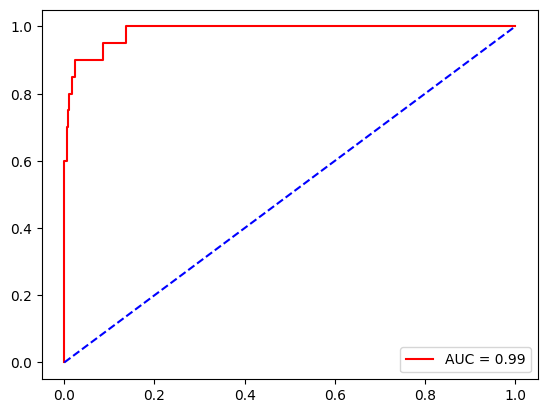

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_s, df_proba['Bear'])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='blue')

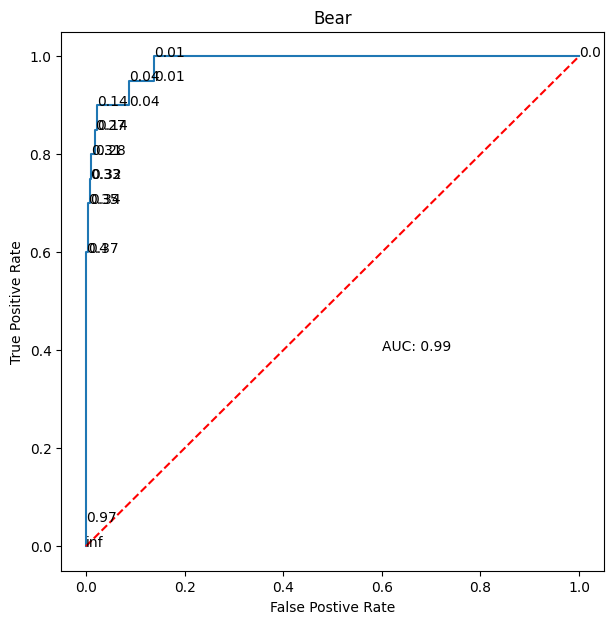

In [68]:
plt.figure(figsize=(7,7))
fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba['Bear'] )
metrica_auc = metrics.auc(fpr, tpr)
plt.plot( fpr, tpr ) 
plt.plot([0,1],[0,1], color='Red', linestyle='--')
plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.6,0.4])
plt.title('Bear')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
for x in range( len(_)):
    plt.annotate( round(_[x],2), [ fpr[x], tpr[x] ])

In [69]:
np.round(_*100,2)

array([  inf, 97.  , 40.12, 37.27, 35.09, 34.42, 32.9 , 31.58, 31.22,
       28.15, 27.28, 14.49, 14.18,  3.75,  3.54,  1.39,  1.35,  0.  ],
      dtype=float32)

Let's set a threshold of 30%.

In [70]:
y_pred_s_30=(df_proba['Bear']>0.3).astype(int)
y_pred_s_30.value_counts()

Bear
0    391
1     21
Name: count, dtype: int64

In [71]:
y_test_s_30=(y_test_s==1).astype(int)
y_test_s_30.value_counts()

0    392
1     20
Name: count, dtype: int64

In [72]:
pd.crosstab(y_test_s,y_pred_s_30, margins= True )

Bear,0,1,All
row_0,,,
0,387,5,392
1,4,16,20
All,391,21,412


In [73]:
print(f'The accuracy of the model is: {metrics.accuracy_score(y_test_s,y_pred_s_30)}')
print(f'The precision of the model is: {metrics.precision_score(y_test_s,y_pred_s_30)}')
print(f'The recall of the model is: {metrics.recall_score(y_test_s,y_pred_s_30)}')

The accuracy of the model is: 0.9781553398058253
The precision of the model is: 0.7619047619047619
The recall of the model is: 0.8


### `4.3. For all labels`

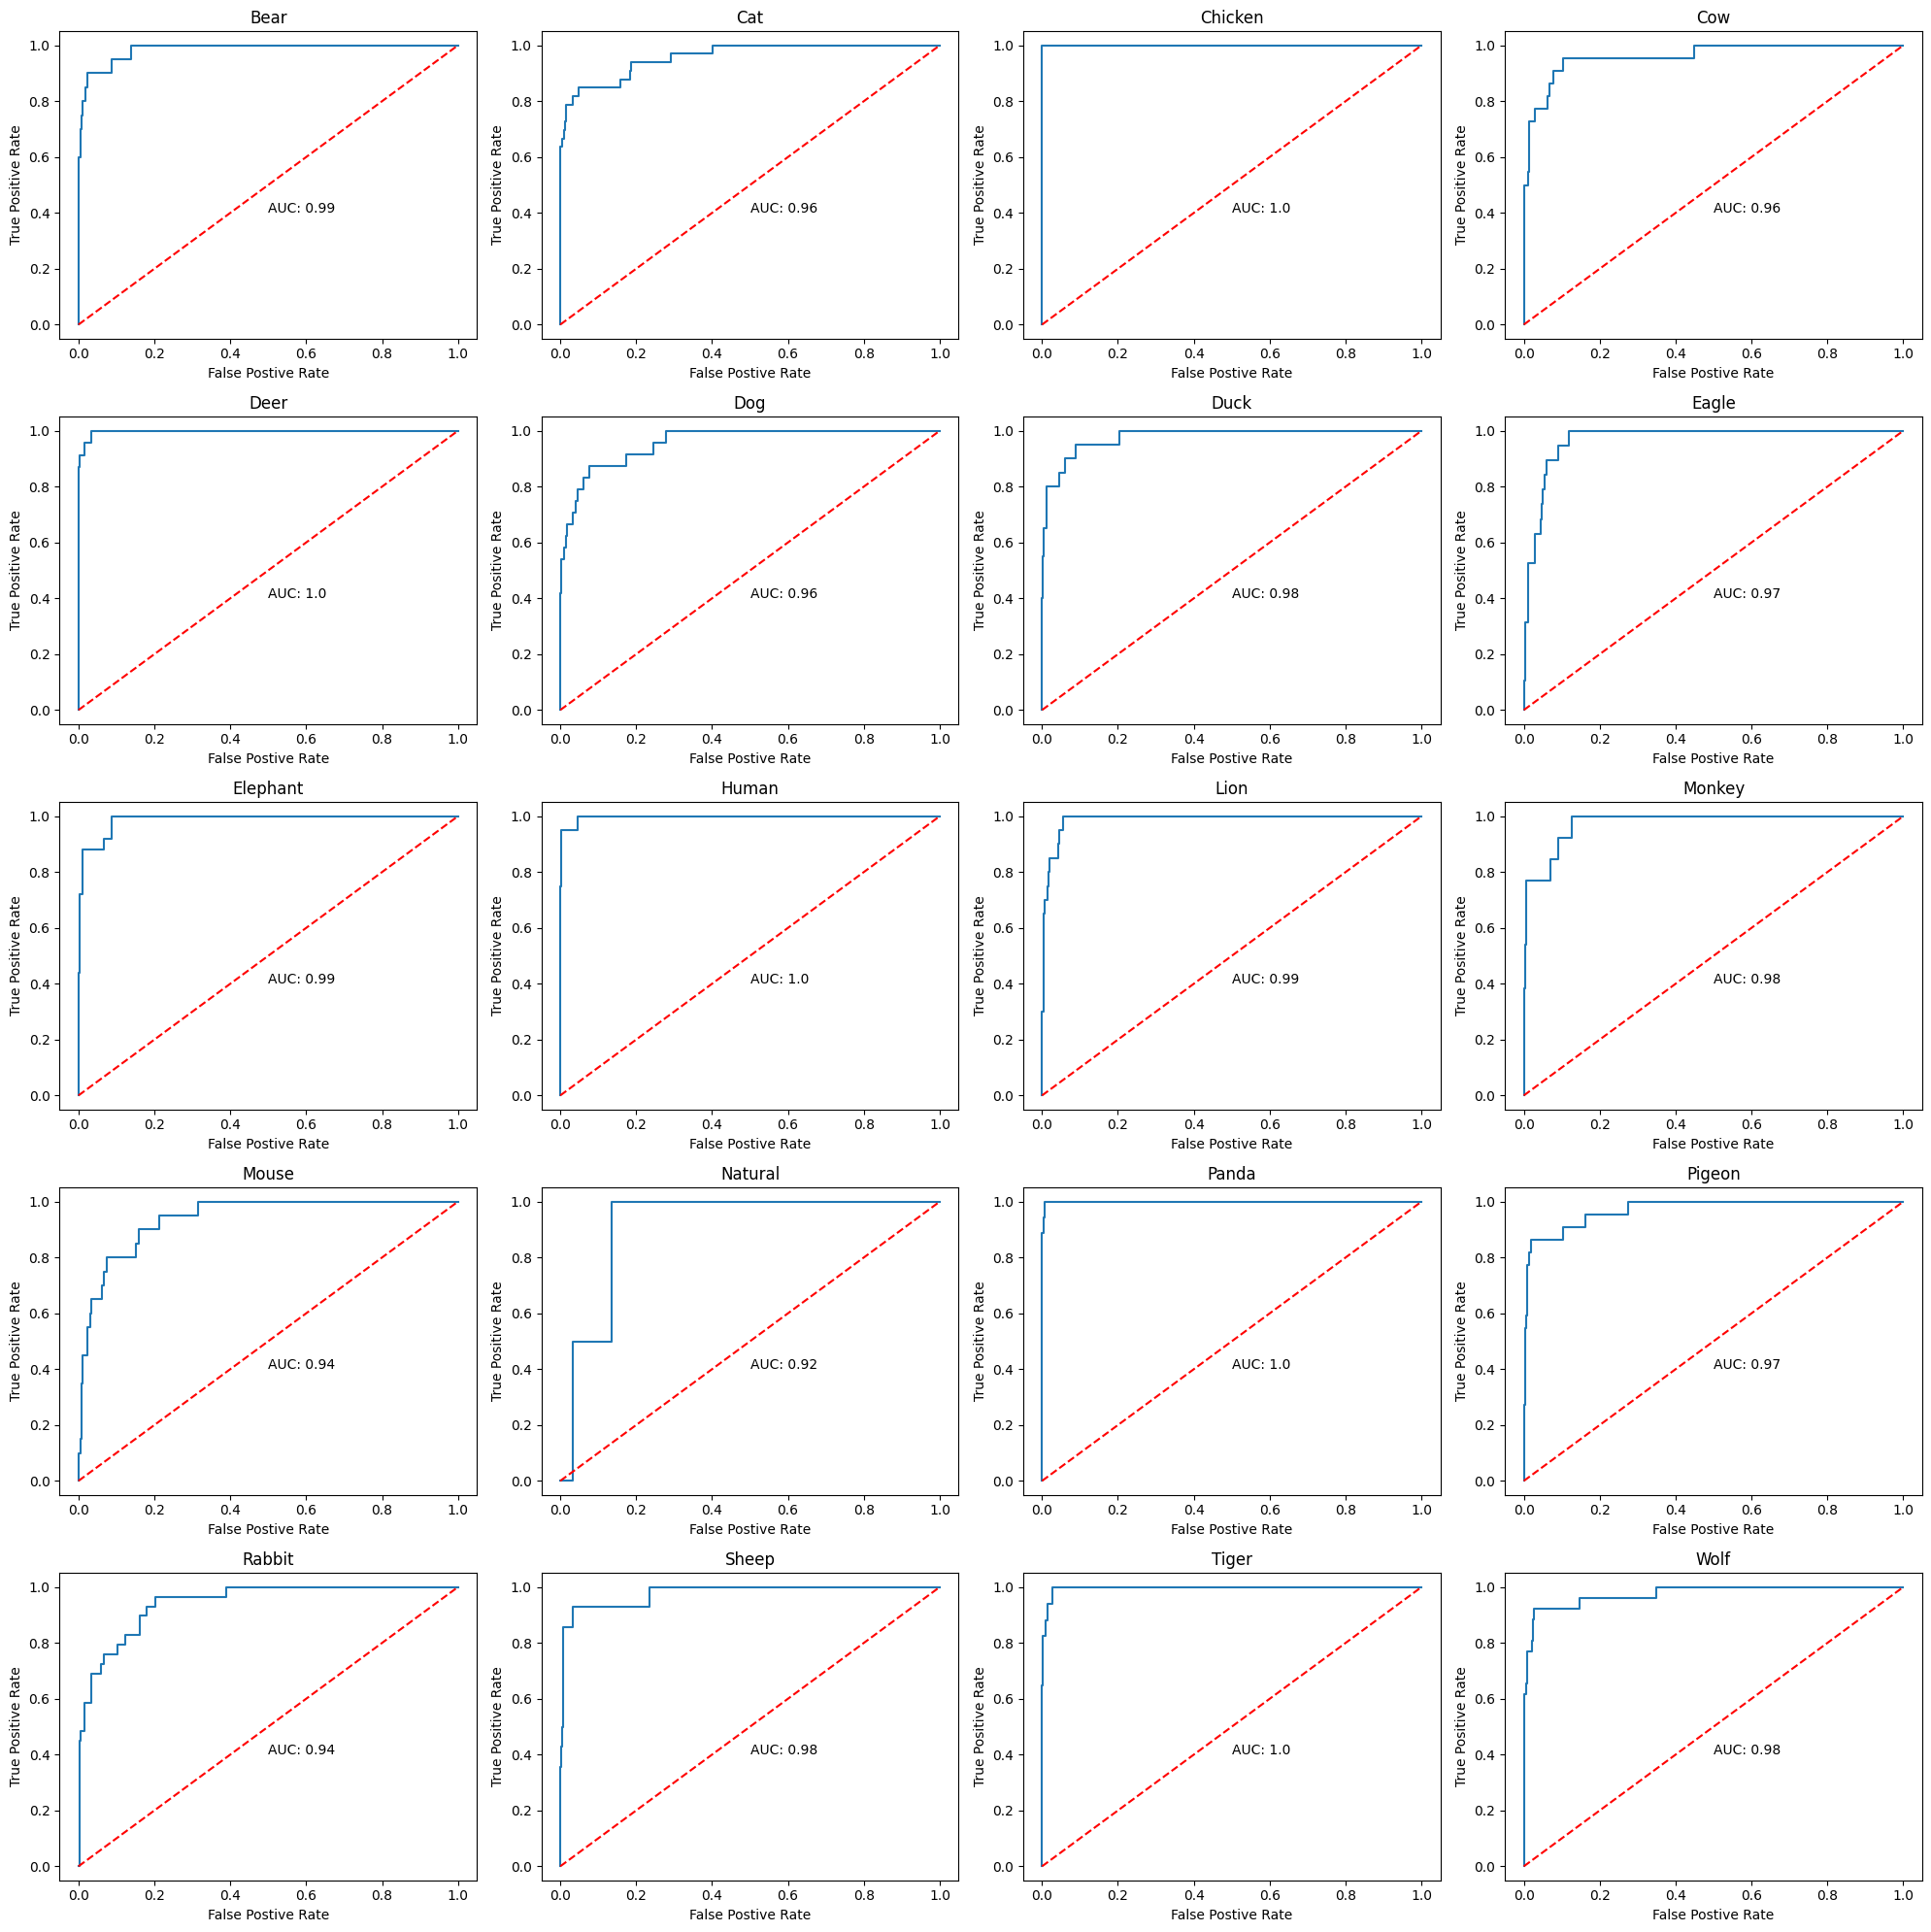

In [74]:
plt.figure(figsize=(20,20))
for i,clase in enumerate(mapeo.values()):
    plt.subplot(5,4,i+1)
    y_test_s=pd.Series(y_test)
    y_test_s=y_test_s.apply(lambda x: mapeo[x])
    y_test_s=(y_test_s==clase).astype(int)
    fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba[clase] )
    metrica_auc = metrics.auc(fpr, tpr)
    plt.plot( fpr, tpr ) 
    plt.plot([0,1],[0,1], color='Red', linestyle='--')
    plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.5,0.4])
    plt.title(clase)
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
plt.tight_layout()

### ``4.4. Other images prediction``

We have some other images in the folde Images. Let's see if our model can identify them correctly.

In [75]:
def model_pipeline(file_path,mapping,model):
    img_path=file_path
    img=plt.imread(img_path)
    img=skimage.transform.resize(img,(80,80,3))
    img=np.array(img)
    predict=model.predict(img.reshape(1,80,80,3),verbose=False)
    results_s=(pd.Series(predict[0],index=[mapping[i] for i in range(20)]).sort_values(ascending=False)[:5]*100).to_dict()
    for key in results_s:
        results_s[key]=round(results_s[key],2)
    return results_s

In [76]:
model_pipeline('Images/eagle.jpg',mapeo,model)

{'Eagle': 82.43, 'Panda': 11.52, 'Sheep': 1.92, 'Cat': 1.11, 'Duck': 0.85}

In [77]:
model_pipeline('Images/lion.jpg',mapeo,model)

{'Duck': 80.46, 'Monkey': 8.03, 'Chicken': 7.06, 'Human': 2.44, 'Lion': 0.57}

In [78]:
model_pipeline('Images/dog_test.jpg',mapeo,model)

{'Mouse': 42.3, 'Monkey': 36.75, 'Rabbit': 8.12, 'Chicken': 5.8, 'Lion': 1.67}

## 5. Transfer Learning

In order to get higher accuracy, let's upload a better model from tensorflow and combine it with our data and prediction settings.

It is better to upload the model instead of calling your web address because we do not know if the server might crash or not.

We are uploading the images again because we need to reshape them to 224x224.

In [79]:
IMG_WEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img,channels = IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img,reshape_dims)

In [80]:
file_list = ['data/' + path + '/' + file for path in os.listdir('data') for file in os.listdir ('data/' + path)]
len(file_list)

2057

In [81]:
img = read_and_decode(file_list[0], [IMG_WEIGHT, IMG_WIDTH])
img.shape

TensorShape([224, 224, 3])

In [82]:
img_tf = [read_and_decode(file, [IMG_WEIGHT, IMG_WIDTH]) for file in file_list]
img_np = np.array(img_tf)
img_np.shape

(2057, 224, 224, 3)

In [83]:
target = [img[img.find('/') + 1 : img.rfind('/') - 4] for img in file_list]
len(target)

2057

In [84]:
x = img_np
y = target

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [86]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [87]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(10, 3))
    for idx, metric in enumerate(['loss', 'accuracy']):
        ax[idx].plot([x for x in range(1, len(history.history[metric]) + 1)], history.history[metric])
        ax[idx].plot([x for x in range(1, len(history.history[f'val_{metric}']) + 1)], history.history[f'val_{metric}'])
        ax[idx].legend([metric, f'val_{metric}'],fontsize=9)

In [90]:
layers = []
layers.append(hub.KerasLayer('./keras_layer', input_shape=(224, 224, 3), trainable=False, name='mobilenet_embedding'))

layers.append(tf.keras.layers.Dense(500, activation='relu', name='H1_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(200, activation='relu', name='H2_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(20, activation='softmax', name='Clasification_layer'))

model = tf_keras.Sequential(layers)

In [92]:
model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
              loss=tf_keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [94]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
26/26 [==============================] - 44s 698ms/step - loss: 1.1998 - accuracy: 0.6742 - val_loss: 0.2396 - val_accuracy: 0.9369
Epoch 2/10
26/26 [==============================] - 17s 647ms/step - loss: 0.2495 - accuracy: 0.9234 - val_loss: 0.2014 - val_accuracy: 0.9393
Epoch 3/10
26/26 [==============================] - 16s 631ms/step - loss: 0.1084 - accuracy: 0.9653 - val_loss: 0.1558 - val_accuracy: 0.9417
Epoch 4/10
26/26 [==============================] - 18s 680ms/step - loss: 0.0640 - accuracy: 0.9812 - val_loss: 0.1374 - val_accuracy: 0.9466
Epoch 5/10
26/26 [==============================] - 17s 665ms/step - loss: 0.0335 - accuracy: 0.9927 - val_loss: 0.1269 - val_accuracy: 0.9539
Epoch 6/10
26/26 [==============================] - 18s 712ms/step - loss: 0.0289 - accuracy: 0.9927 - val_loss: 0.1673 - val_accuracy: 0.9369
Epoch 7/10
26/26 [==============================] - 15s 587ms/step - loss: 0.0293 - accuracy: 0.9909 - val_loss: 0.1198 - val_accuracy: 0.9393

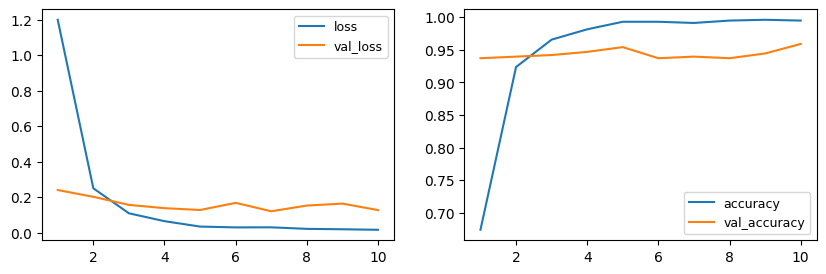

In [95]:
training_plot(['loss', 'accuracy'], history)

We are going to save the model.

In [101]:
model.save('model/model_tf', save_format='tf')

INFO:tensorflow:Assets written to: model/model_tf\assets


INFO:tensorflow:Assets written to: model/model_tf\assets
